# TODO REVISE EVERYTHING!!!

<a id="main"></a>
# A preliminary investigation on Capitol Hill's trading performance

US members of Congress hold a unique position with regards to access to financially valuable information. To promote transparency and prevent insider trading, each trade made by a member of congress is mandated to be declared by the Stop Trading on Congressional Knowledge (STOCK) Act. Consequently, this act grants the public a unique view into the financial activities of congressional members.

Concerns whether members of congress abuse their positions to profit from insider information exist, but distinguishing insider trading may not be straightforward. Differences between shadow insider trading complicate things further.

Evidence suggests that congress consistently out performs the market. For example X shows that congress and family yield 12%. [QuiverQuant](https://www.quiverquant.com/congresstrading/) replicates congressional trades in a long-short strategy and boasts a 300% return since 2020. However, it would be ***presumptuous to assume that every trade Congress makes is based on exclusive information.

Against this background, I investigate whether politicians exploit insider or exclusive information to achieve above-market/above-industry returns. To do this, I proxy "insider information" by aligning a politician's committee membership with the industry or sector associated with their traded firms. Then, I compare trades made by politicians to the respective industry index.

<a id="desc"></a>
## 1. Project description

### Identifying trades made using private information

There are a number of data-sources online that can be combined to identify how "informed" congressional trades are. An easy is to simply matching the a congress member's committee membership with the industry and sector of a traded firm. For example, if a congress member is on a defence committee, they may have access to defence specific information. That is, they may learn that a company is about to be awarded a government contract to supply the military. The congress member has this information and can act on it before it is reflected in the price. Therefore, should a congress member that is on the defence committee buy or sell a stock that is related to defence, it is likely that this was done with private information. 

A straightforward matching could be too restrictive. That is, if we match "defence committee" congress members with "defence sector" firms, we may have a restricted view. Many firms (e.g., tech firms) could be goverment contractors. Therefore, we take a slightly more complex approach (albeit still not perfect) of using a language model to encode the committees and firm industry, and match the encoded vectors via a similarity metric. While this could still lead to erroneous results (e.g., "natural resources, energy and mineral resources" committee and "computer hardware" industry recieving high similarity scores), it still provides a better view than the simple matching approach.

### Data description

There are a number of different dataset we need to complete this project. In the following, I outline each of the datasets and how I collected the data.

#### Trades made by Congress members

In accordance with the STOCK act, congress members must declair their trades. Trades are recorded in a [public database](https://disclosures-clerk.house.gov/FinancialDisclosure) but are cumbersome to parse as the information is recorded in pdfs (see [this](https://disclosures-clerk.house.gov/public_disc/ptr-pdfs/2023/20023670.pdf) for an example.) [CapitolTrades.com](https://www.capitoltrades.com/trades) is a platform which provides the parsed and structured data for free. 

I scraped the data from the [CapitolTrades.com](https://www.capitoltrades.com/trades) HTML using [`selenium`](https://selenium-python.readthedocs.io/installation.html). See `scrape_data.py` for more detail.

#### Historical congress committee membership

Historical committee membership can be found on [ballotpedia.org](ballotpedia.org). This website has a page for every historical congress member with their historical committee membership (see [Doug Lamborn](https://ballotpedia.org/Doug_Lamborn) for an example).

Again, I scraped the data from the [ballotpedia.org](ballotpedia.org) HTML using [`selenium`](https://selenium-python.readthedocs.io/installation.html). Specifically, for each `politician` in the capitol-trades dataset, I scraped the corresponding historical committee memberships from the `www.ballotpedia.org/politician_name`. See `scrape_data.py` for more detail.

#### Firm's sector and industry

To match firms to committees, I also need information each firms main operating industry and sector. This data is provided by [finance.yahoo.com](finance.yahoo.com). Yahoo provides an API for easy data retrieval of a firm's (specified by a ticker) meta data. The universe of firms for which I need data are all the firms present in the capitol-trades dataset.

#### Historical price data for traded firms

Historical price data can be retrieved from [finance.yahoo.com](finance.yahoo.com). This data is needed to construct and evaluate the portfolios that mimic the congressional trades. Yahoo provides an API for easy data retrieval of a firm's (specified by a ticker) price data between a start and end date. I use the first date for which I have a congressional trade as the start date, and today as the end date. The universe of firms for which I need data are all the firms present in the capitol-trades dataset. To simplify things, I dropped all firms without price data.

### Constructing portfolios

Constructing the portfolios seems to be the crux of the project. I will first outline the intial idea before discussing the challenges faced.

#### Idea

I first want to replicate the portfolio on [QuiverQuant](https://www.quiverquant.com/congresstrading/), who created a long-short portfolio copying all congress trades. The portfolio is leveraged 130% long and 30% short, and is rebalanced weekly. As no other information is specified, I ignore all trading costs (transaction cost, shorting fees, slippage, etc.). Furthermore, I don't take tick-sizes into consideration and assume I can purchase any arbitrary fraction of a share. I would compare the performance of this portfolio to the S&P500 to see how it compares to the market.

Then, in the second step, I would create the same long-short portfolio (using the same rules) on a reduced set of the trades. In a first step, I wanted to select all trades from the committee with the most associated trades. I would compare this portfolio with a corresponding industry index.

#### Challenges

The main challenge that I had to contend with when constructing the portfolio is as follows: The capitol-trading dataset only contains discrete information on the value of a trade. For example, whether the trade was between $5'000 and $10'000 or between $10'000 and $20'000. This makes it very difficult to determine whether a position is still open. Therefore, constructing a portfolio on current positions becomes very difficult.

\######TODO
Furthermore, as I don't have detailed information about [QuiverQuant](https://www.quiverquant.com/congresstrading/)'s assumptions it is very difficult to replicate their portfolio. In the end, I offer 3 replication attempts; each underperforming the S&P500 on average and the [QuiverQuant](https://www.quiverquant.com/congresstrading/) portfolio. Without constructing a solid long-short porfolio on the full universe of trades, constructing a portfolio on private-information trades seems senseless.

Still, in this notebook, I offer my current progress.

### Next steps and future extensions

There are a number of extensions that I envisioned that would make this project more interesting, however, due to the lack of time was unable to implement:

- Invest more time in matching firms to committee to better proxy for "insider information".
- Use [government contract](https://www.contractdirectory.gov/contractdirectory/) and [policy-vote databases](https://www.govtrack.us/congress) to better identify "insider trading" using language models to extract information.

<a id="status"></a>
## 2. Status report

`[X]` Scraping data $\\$
`[X]` Load data $\\$
`[X]` Clean data $\\$
`[X]` [QuiverQuant](https://www.quiverquant.com/congresstrading/) long-short portfolio replication $\\$
`[X]` Clean committee data $\\$
`[X]` Match committee with $\\$
`[ ]` Long-short insider trading portfolio $\\$

<a id="toc"></a>
## 3. Table of content

[A preliminary investigation on Capitol Hill's trading performance](#main)
1. [Project description](#desc)
2. [Status report](#status)
3. [Table of content](#toc)
4. [Setup workspace](#workspace)
5. [Load data](#data1)
    1. [Load capitol-trades data](#CTdata)
    2. [Load yahoo-finance data](#YFdata)
    3. [Get S&P500 data](#SPXdata)
6. [Capitol Hill long-short portfolio](#CPportfolio)
    1. [Strategy 1](#strat1)
    2. [Strategy 2](#strat2)
    3. [Strategy 3](#strat3)
    3. [Results](#results1)
7. [Compute insider Capitol Hill long-short portfolio](#insider)
    1. [Language model](#lm)
    2. [Load data](#data2)
        1. [Load firm industry data](#industrydata)
        2. [Load committee data](#committeedata)
    3. [](#)
8. []


<a id="workspace"></a>
## 4. Setup workspace

In [1]:
import os
import yaml
from datetime import  timedelta

import string
import re 

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from utils import compute_average_from_range, get_committee_list, encode_committees, clean_committees

import yfinance as yf
from pandas_datareader import data as pdr

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

yf.pdr_override()


In [2]:
%matplotlib inline

In [3]:
ROOT = os.path.dirname(os.getcwd())
PATH_SRC = os.path.join(ROOT, 'src')
PATH_DATA = os.path.join(ROOT, 'data')
PATH_DATA_PRICES = os.path.join(PATH_DATA, 'yfinance_prices')

In [4]:
min_week = pd.to_datetime('2020-09-03')
max_week = pd.to_datetime('2023-08-15')
dates = pd.date_range(min_week, max_week, freq='W') - timedelta(days=2)

<a id="data1"></a>
## 5. Load data

<a id="CTdata"></a>
### 5.1. Load capitol-trades data

In this section, I load and clean the data that was scraped from [CapitolTrades.com](https://www.capitoltrades.com/trades).

- As the data is the format '`dd MMM YYYY`', where '`MMM`' is the string abreviation of the month (e.g., '`Jan`'), I needed to create a `date_parser` to convert this format into a datetime stamp.
- Drop all firms for which I don't have pricing data.
- Drop small trades.
- Drop trades of type: `exchange` and `recieve`. Only keep trades of type:  `buy` and `sell`.
- Drop trades made by politician's children.
- Round the trade execution date to nearest friday (to get week closing price).

In order to compute the long-short portfolio I use a few approaches. One of the approaches is to use the value-of-trade bucket's to score the congress member's confidence. That is, larger trade sizes indicate confidence in trade. To do this we:

- Convert upperbound of size bucket to log scale score (to make linear).
- Assume position size is average of bucket's upper and lower bound.

For more information see [Section 6](#CPportfolio).

In [5]:
# Load trades data
def date_parser(string_list):
    month_name = dict((k, v+1) for v, k in enumerate(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']))
    return [f"{x.split(' ')[2]} {int(month_name[x.split(' ')[4]]):02d} {int(x.split(' ')[3]):02d}" for x in string_list]

df_trades = pd.read_csv(
    os.path.join(PATH_DATA, 'CapitolTrades_raw.csv'),
    parse_dates=[
        'traded'
        ],
    date_parser=date_parser,
    usecols=[
        'politician',
        'trade_issuer',
        'ticker',
        'traded',
        'owner',
        'type',
        'size',
        'price'
        ],
    dtype={
        'owner': 'category',
        'politician': 'category',
        'type': 'category',
        },
)

# Check which firms have price data for
firms = [x.strip('.csv')for x in os.listdir(PATH_DATA_PRICES)]

# Format tickers to correspond with pricing data
df_trades.dropna(subset=['ticker'], inplace=True)
df_trades['ticker'] = df_trades['ticker'].apply(lambda x: x.strip(':US'))
df_trades['ticker'] = df_trades['ticker'].astype('category')

# Drop trades I don't have pricing data for
df_trades = df_trades[df_trades.ticker.isin(firms)]

# Drop small trades
df_trades = df_trades[df_trades['size'] != ' < 1K']

# Convert upperbound of size bucket to log scale score (to make linear)
df_trades['size_score'] = df_trades['size'].apply(lambda x: np.log(float(x.split('–')[-1].replace('K', '000').replace('M', '000000'))))

# Assume position is average of bucket's upper and lower bound
df_trades['average_size'] = df_trades['size'].apply(compute_average_from_range)

df_trades.drop(columns=['size'], inplace=True)

# Drop exchanges and recieves (because I don't know what they are)
df_trades = df_trades[df_trades['type'].isin([' buy', ' sell'])]
df_trades['type'] = df_trades['type'].cat.remove_unused_categories()

# Convert buy/sell to 1/-1
df_trades['type_bool'] = (df_trades['type'] == ' buy').astype(int) * 2 - 1
df_trades.drop(columns=['type'], inplace=True)

# Convert size_score to contain buy/sell information
df_trades['size_score'] *= df_trades['type_bool']
df_trades['average_size'] *= df_trades['type_bool']

# Drop trades by children
df_trades = df_trades[df_trades['owner'] != ' Child']
df_trades['owner'] = df_trades['owner'].cat.remove_unused_categories()

# Round date to nearest friday (to get week closing price)
df_trades['week_date'] = pd.to_datetime(df_trades.traded.dt.to_period('W').dt.end_time.dt.date - timedelta(days=2))

df_trades.head(20)


,politician,trade_issuer,ticker,traded,owner,price,size_score,average_size,type_bool,week_date
1,Doug Lamborn,NetApp Inc,NTAP,2023-08-07,Undisclosed,78.29,-10.819778,-32500.0,-1,2023-08-11
2,Doug Lamborn,NetApp Inc,NTAP,2023-08-08,Undisclosed,77.89,10.819778,32500.0,1,2023-08-11
3,Doug Lamborn,NetApp Inc,NTAP,2023-08-07,Undisclosed,78.29,-10.819778,-32500.0,-1,2023-08-11
4,Doug Lamborn,NetApp Inc,NTAP,2023-08-08,Undisclosed,77.89,10.819778,32500.0,1,2023-08-11
5,Doug Lamborn,NetApp Inc,NTAP,2023-08-07,Spouse,78.29,-10.819778,-32500.0,-1,2023-08-11
6,Doug Lamborn,NetApp Inc,NTAP,2023-08-08,Spouse,77.89,10.819778,32500.0,1,2023-08-11
8,Bill Keating,PepsiCo Inc,PEP,2023-08-10,Undisclosed,N/A,10.819778,32500.0,1,2023-08-11
11,Lois Frankel,Fluor Corp,FLR,2023-08-04,Undisclosed,35.94,-9.615805,-8000.0,-1,2023-08-04
12,Lois Frankel,Insperity Inc,NSP,2023-08-07,Undisclosed,97.4,-9.615805,-8000.0,-1,2023-08-11
13,Lois Frankel,Insperity Inc,NSP,2023-08-04,Undisclosed,94.15,-9.615805,-8000.0,-1,2023-08-04


<a id="YFdata"></a>
### 5.2. Load yahoo-finance data

In this section, I load the [finance.yahoo.com](finance.yahoo.com) historical price data. Each ticker's price data is stored in its own file title `ticker.csv`. The steps are as follows:

- Load all the files to one dataframe.
- Drop all prices that don't correspond to the weekly closing prices.
- Create new variable with shifted closing prices forward. These are used to determine the value of the stock next week.

Note, the final step is only correct if we have one observation per week after the second step. If we are missing a week (which I cannot assume that we are not), we would allocate the next period's price to the wrong date. However, this error should not occur frequently and hence I ignore it for the time being.

In [6]:
df_prices = pd.DataFrame()
for ticker in df_trades.ticker.dropna().unique():
    df_ticker_price = pd.read_csv(os.path.join(PATH_DATA_PRICES, f'{ticker}.csv'))
    df_ticker_price['Ticker'] = ticker
    df_prices = df_prices.append(df_ticker_price.loc[:, ['Ticker', 'Date', 'Close']])

df_prices['Date'] = pd.to_datetime(df_prices['Date'])
df_prices = df_prices[df_prices['Date'].dt.day_of_week == 4]

df_prices['Ticker'] = df_prices['Ticker'].astype('category')
df_prices['Close_lag'] = df_prices.groupby('Ticker')['Close'].shift(-1)

df_prices

,Ticker,Date,Close,Close_lag
3,NTAP,2020-09-04,46.400002,44.090000
7,NTAP,2020-09-11,44.090000,42.610001
12,NTAP,2020-09-18,42.610001,41.959999
17,NTAP,2020-09-25,41.959999,42.759998
22,NTAP,2020-10-02,42.759998,45.869999
...,...,...,...,...
730,FHB,2023-07-28,21.360001,20.320000
735,FHB,2023-08-04,20.320000,20.129999
740,FHB,2023-08-11,20.129999,19.219999
745,FHB,2023-08-18,19.219999,18.680000


<a id="SPXdata"></a>
### 5.3. Get S&P500 data

Finally, get the S&P500 (SPX) data for comparison purposes and drop all observations that don't correspond to weekly closing prices.

In [7]:
spx = pdr.get_data_yahoo('^spx', start=min_week.strftime('%Y-%m-%d'), end=max_week.strftime('%Y-%m-%d'))
spx['Ticker'] = 'SPX'
spx = spx.loc[spx.index.day_of_week == 4, ['Ticker', 'Close']]

[*********************100%%**********************]  1 of 1 completed


<a id="CPportfolio"></a>
## 6. Capitol Hill long-short portfolio

In a first step, I want to replicate a congress-copying portfolio that works. Specifically, I want to replicate the long-short portfolio by [QuiverQuant](https://www.quiverquant.com/congresstrading/) (performance displayed below).

![QuiverQuant's long-short portfolio](../assets/qq_longshort.png "QuiverQuant's long-short portfolio performance")

However, there are a number of undisclosed decisions that [QuiverQuant](https://www.quiverquant.com/congresstrading/) makes that determine the success of the strategy. As outlined above, I do not have access to the exact value of the trade nor the number of shares purchased. Therefore, I cannot precisely determine when a position has been closed. With weekly rebalancing, unless the anticipated price move happens immediately in the following week, I may miss out on price movements if done incorrectly.

Therefore, I try three strategies and pick the best one.

We provide an initial wealth of $1'000'000.

In [8]:
wealth_initial = 1_000_000

<a id="strat1"></a>
### 6.1. Strategy 1

For this strategy, we will use the `size_score` and `average_score` variables created in [Section 5.1](#CTdata).

To compute `size_score`, we log-linearized the upperbound of value-of-trade bucket (`size`). That is, we converted the buckets as follows:

| Original     | Step 1              | Step 2               | Step 3           | `size_score` |  
|--------------|---------------------|----------------------|------------------|--------------|
| '1K–15K'     | '1000–15000'        | [1000, 15000]        | np.log(15000)    | 9.615        |
| '15K–50K'    | '15000–50000'       | [15000, 50000]       | np.log(50000)    | 10.819       |
| '50K–100K'   | '50000–100000'      | [50000, 100000]      | np.log(100000)   | 11.512       |
| '100K–250K'  | '100000–250000'     | [100000, 250000]     | np.log(250000)   | 12.429       |
| '250K–500K'  | '250000–500000'     | [250000, 500000]     | np.log(500000)   | 13.122       |
| '500K–1M'    | '500000–1000000'    | [500000, 1000000]    | np.log(1000000)  | 13.815       |
| '1M–5M'      | '1000000–5000000'   | [1000000, 5000000]   | np.log(5000000)  | 15.424       |
| '5M–25M'     | '5000000–25000000'  | [5000000, 25000000]  | np.log(25000000) | 17.034       |

Each consecutive column in the above table constitutes a processing step. The final column provides the log size weights (`size_score`). We can see that we have approximately linearized the score. Finally, we multiply the `size_score` for an observation by -1 if the trade is of `type=='sell'`.

In each week, we aggregate (sum) the `size_score` across each `politician` and `trade` for each `ticker`. This value then gives a number with which we can rank the firms by week. A large positive value indicates that congress is bullish on the firm, while a large negative indicates that congress is bearish on the firm (in the given week).

We then take a long position in the top third and short position in the bottom third. Our long position will trade with 130% of our current wealth, while the short position will trade with 30% of our current wealth (inline with [QuiverQuant](https://www.quiverquant.com/congresstrading/)).

To weight the firm holdings in the portfolio we use the `average_score` variable. The average score was computed as follows:

| Original     | Step 1              | Step 2               | `average_score` |
|--------------|---------------------|----------------------|-----------------|
| '1K–15K'     | '1000–15000'        | [1000, 15000]        | 8000            |
| '15K–50K'    | '15000–50000'       | [15000, 50000]       | 32500           |
| '50K–100K'   | '50000–100000'      | [50000, 100000]      | 75000           |
| '100K–250K'  | '100000–250000'     | [100000, 250000]     | 175000          |
| '250K–500K'  | '250000–500000'     | [250000, 500000]     | 375000          |
| '500K–1M',   | '500000–1000000',   | [500000, 1000000],   | 750000          |
| '1M–5M'      | '1000000–5000000'   | [1000000, 5000000]   | 3000000         |
| '5M–25M'     | '5000000–25000000'  | [5000000, 25000000]  | 15000000        |

Each consecutive column in the above table constitutes a processing step. The final column provides the `average_score`, which is an average of the upper and lower bucket bound. Finally, we multiply the `average_score` for an observation by -1 if the trade is of `type=='sell'`.

Then, for both the long and short subsets of trades, we use `average_score` to compute the relative weightings. That is, independently, for each subset, we compute the relative share of a firm's absolute `average_score` to the rest of the firms in said subset.

Then, we buy (sell) the long (short) firms, and hold for one week. The prices at which we trade are the week-end (Friday) closing prices.

In [9]:
ws_a1 = [wealth_initial]
for i, date in enumerate(dates):
    wealth = ws_a1[-1]

    portfolio = df_trades.loc[(df_trades.week_date == date), :].copy()
    portfolio['ticker'] = portfolio['ticker'].cat.remove_unused_categories()

    average_size = portfolio.groupby('ticker')['average_size'].sum().to_frame().reset_index()
    portfolio = portfolio.groupby('ticker')['size_score'].sum().sort_values().to_frame().reset_index()

    portfolio = portfolio.merge(average_size, how='left', on='ticker')
    portfolio = portfolio.merge(df_prices.loc[df_prices.Date == date, :], how='left', left_on='ticker', right_on='Ticker').drop(columns=['Ticker'])
    portfolio.dropna(subset=['Close', 'Close_lag'], inplace=True)

    cutoff = int(portfolio.shape[0] / 3)
    
    if portfolio.shape[0] > 0:

        short = portfolio[:cutoff].copy()
        long = portfolio[-cutoff:].copy()

        long['weights'] = np.abs(long['average_size']) / np.abs(long['average_size']).sum()
        short['weights'] = np.abs(short['average_size']) / np.abs(short['average_size']).sum()

        scale = 0.3 if short.shape[0] > 0 else 0.0

        long['holding_value'] = long['weights'] * wealth * (1 + scale)
        short['holding_value'] = short['weights'] * wealth * -scale

        long['holding_size'] = long['holding_value'] / long['Close']
        short['holding_size'] = short['holding_value'] / short['Close']

        long['holding_value_next'] = long['holding_size'] * long['Close_lag']
        short['holding_value_next'] = short['holding_size'] * short['Close_lag']

        # long['return'] = long['holding_value_next'] - long['holding_value']
        # short['return'] = short['holding_value_next'] - short['holding_value']

        wealth_long_new = long['holding_value_next'].sum()
        wealth_short_new = short['holding_value_next'].sum()

        wealth_new = wealth_long_new + wealth_short_new

    ws_a1.append(wealth_new)


<a id="strat2"></a>
### 6.2. Strategy 2

This strategy is similar to the [Attempt 1](#attempt1) strategy. The difference is that we do not aggregate the `size_score` across `politicians` and `trades`. We simply rank each trade according to its confidence and select to top and bottom third respectfully. The weight of each position is again determined by `average_size`, however, with this strategy, multiple positions on one firm can be open simultaneously (both multiple long, multiple short, and a mix of long and short). 

In the case that a long and short position are opened simultaneously, this then results in the same outcome as if part of an investor's wealth is not invested, but held in cash.

This strategy avoids having to make any ruling on how to aggregate trades.

In [10]:
wealth_initial = 1_000_000
ws_a2 = [wealth_initial]
for i, date in enumerate(dates):
    wealth = ws_a2[-1]

    portfolio = df_trades.loc[(df_trades.week_date == date), :].copy().sort_values('size_score')
    portfolio['ticker'] = portfolio['ticker'].cat.remove_unused_categories()

    portfolio = portfolio.merge(df_prices.loc[df_prices.Date == date, :], how='left', left_on='ticker', right_on='Ticker').drop(columns=['Ticker'])
    portfolio.dropna(subset=['Close', 'Close_lag'], inplace=True)

    cutoff = int(portfolio.shape[0] / 3)
    
    if portfolio.shape[0] > 0:

        short = portfolio[:cutoff].copy()
        long = portfolio[-cutoff:].copy()

        long['weights'] = np.abs(long['average_size']) / np.abs(long['average_size']).sum()
        short['weights'] = np.abs(short['average_size']) / np.abs(short['average_size']).sum()

        scale = 0.3 if short.shape[0] > 0 else 0.0

        long['holding_value'] = long['weights'] * wealth * (1 + scale)
        short['holding_value'] = short['weights'] * wealth * -scale

        long['holding_size'] = long['holding_value'] / long['Close']
        short['holding_size'] = short['holding_value'] / short['Close']

        long['holding_value_next'] = long['holding_size'] * long['Close_lag']
        short['holding_value_next'] = short['holding_size'] * short['Close_lag']

        # long['return'] = long['holding_value_next'] - long['holding_value']
        # short['return'] = short['holding_value_next'] - short['holding_value']

        wealth_long_new = long['holding_value_next'].sum()
        wealth_short_new = short['holding_value_next'].sum()

        wealth_new = wealth_long_new + wealth_short_new

    ws_a2.append(wealth_new)


<a id="strat3"></a>
### 6.3. Strategy 3

The final strategy attempts to determine which positions are open. That is, rather than just buying and selling based on weekly sentiment, I trade based on persistent sentiment.

I do this as follows:

First, I create a dataframe with one observation for each `ticker`-`week_date` combination (`new_index`).

Then, for each week, I aggregate (sum) the `size_scores` across `politicians` and `trades`. Next, I aggregate (cumsum) the aggregated `size_scores` values. This computes an approximation of the current week's open position value. Then, I reindex this table with the new dataframe (`new_index`). This inserts `NAN` values for weeks where a firm is untraded. We first fill the `NAN` with a forward fill and then fill the remaining with 0. The forward fill rolls the previous non-`NAN` value forward.

Now, for each firm-week we have one observation of an approximation of the current open value.

Again, we construct the weekly portfolio by ranking the firms each week and selecting top and bottom third to long and short, respectively.

The companies are weighted using these aggregated `size_scores` since we dropped the `average_size` variable. We only need to exponentiate them (`np.exp`) to un-linearize them.


In [11]:
new_index = pd.MultiIndex.from_product([df_trades['ticker'].unique(), dates], names=['ticker', 'week_date'])

df_trades = df_trades.sort_values(by=['ticker', 'week_date'])

weekly_cumulative = df_trades.groupby(['ticker', 'week_date'])['size_score'].sum().groupby(level=0).cumsum().reindex(new_index)
weekly_cumulative = weekly_cumulative.ffill().fillna(0).to_frame()

weekly_cumulative = weekly_cumulative.merge(df_prices, how='left', left_index=True, right_on=['Ticker', 'Date'])
weekly_cumulative.dropna(subset=['Close', 'Close_lag'], inplace=True)

weekly_cumulative['Ticker'] = weekly_cumulative['Ticker'].astype('category')
weekly_cumulative

,size_score,Ticker,Date,Close,Close_lag
3,0.000000,NTAP,2020-09-04,46.400002,44.090000
7,-28.847416,NTAP,2020-09-11,44.090000,42.610001
12,0.000000,NTAP,2020-09-18,42.610001,41.959999
17,0.000000,NTAP,2020-09-25,41.959999,42.759998
22,0.000000,NTAP,2020-10-02,42.759998,45.869999
...,...,...,...,...,...
720,-19.231611,FHB,2023-07-14,19.240000,20.940001
725,-19.231611,FHB,2023-07-21,20.940001,21.360001
730,-19.231611,FHB,2023-07-28,21.360001,20.320000
735,-19.231611,FHB,2023-08-04,20.320000,20.129999


In [12]:
ws_a3 = [wealth_initial]
for i, date in enumerate(dates):
    wealth = ws_a3[-1]

    portfolio = weekly_cumulative.loc[(weekly_cumulative.Date == date) & (weekly_cumulative.size_score != 0), :].copy().sort_values('size_score')
    portfolio['Ticker'] = portfolio['Ticker'].cat.remove_unused_categories()

    cutoff = int(portfolio.shape[0] / 3)
    
    if portfolio.shape[0] > 0:

        short = portfolio[:cutoff].copy()
        long = portfolio[-cutoff:].copy()

        long['weights'] = np.exp(np.abs(long['size_score'])) / np.exp(np.abs(long['size_score'])).sum()
        short['weights'] = np.exp(np.abs(short['size_score'])) / np.exp(np.abs(short['size_score'])).sum()

        scale = 0.3 if short.shape[0] > 0 else 0.0

        long['holding_value'] = long['weights'] * wealth * (1 + scale)
        short['holding_value'] = short['weights'] * wealth * -scale

        long['holding_size'] = long['holding_value'] / long['Close']
        short['holding_size'] = short['holding_value'] / short['Close']

        long['holding_value_next'] = long['holding_size'] * long['Close_lag']
        short['holding_value_next'] = short['holding_size'] * short['Close_lag']

        # long['return'] = long['holding_value_next'] - long['holding_value']
        # short['return'] = short['holding_value_next'] - short['holding_value']

        wealth_long_new = long['holding_value_next'].sum()
        wealth_short_new = short['holding_value_next'].sum()

        wealth_new = wealth_long_new + wealth_short_new

    ws_a3.append(wealth_new)


<a id="results1"></a>
### 6.4. Results

We compare the results of the three strategies and find that [Strategy 1](#strat1) performs best. This seems intuitive, as [Strategy 2](#strat2) leaves money on the table, and [Strategy 3](#strat3) is likely a poor approximation of open positions. For the subsequent section, we will construct the portfolio identical to [Strategy 1](#strat1).

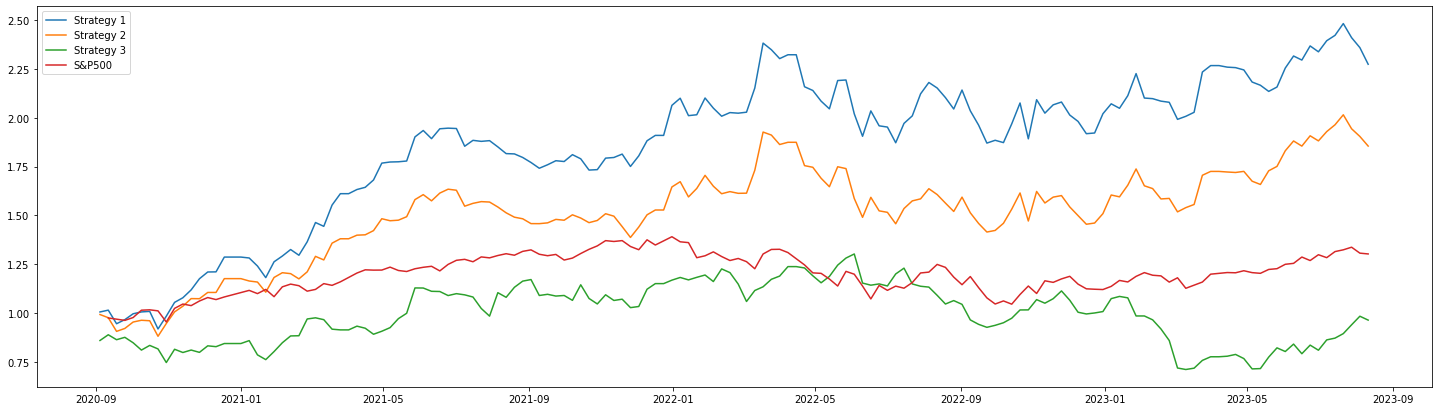

In [13]:
n_spx_shares = wealth_initial / spx['Close'].iloc[0]

plt.figure(figsize=(25, 7))
plt.plot(dates, [w/wealth_initial for w in ws_a1[1:]], label='Strategy 1')
plt.plot(dates, [w/wealth_initial for w in ws_a2[1:]], label='Strategy 2')
plt.plot(dates, [w/wealth_initial for w in ws_a3[1:]], label='Strategy 3')
plt.plot(spx.index[1:], (spx['Close'].iloc[1:] * n_spx_shares) / wealth_initial, label='S&P500')
plt.legend()
plt.show()
plt.close()

<a id="insider"></a>
## 7. Compute insider Capitol Hill long-short portfolio

In this section, I will attempt to compute a long-short portfolio for a single ... TODO

<a id="lm"></a>
### 7.1. Language model

!pip install -U sentence-transformers

https://github.com/google-research/bert/blob/master/README.md

In [16]:
model = SentenceTransformer("bert-base-uncased")

No sentence-transformers model found with name /home/lpupp/.cache/torch/sentence_transformers/bert-base-uncased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /home/lpupp/.cache/torch/sentence_transformers/bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification

<a id="data2"></a>
### 7.2. Load Data

<a id="industrydata"></a>
#### 7.2.1. Load firm industry data

In [17]:
df_sectors = pd.read_csv(os.path.join(PATH_DATA, 'YahooFinance_industry.csv')).dropna(subset=['industry', 'sector'])
df_sectors['encoded_sector'] = model.encode([f'{x} {y}' for x, y in zip(df_sectors.industry, df_sectors.sector)]).tolist()

df_trades = df_trades.merge(df_sectors, how='left', on='ticker')
df_trades['trade_year'] = df_trades.traded.dt.year
df_trades.dropna(subset=['industry', 'sector'], inplace=True)
df_trades.head(10)

,politician,trade_issuer,ticker,traded,owner,price,size_score,average_size,type_bool,week_date,sector,industry,encoded_sector,trade_year
0,Ro Khanna,Agilent Technologies Inc,A,2020-11-27,Spouse,114.09,9.615805,8000.0,1,2020-11-27,Healthcare,Diagnostics & Research,"[0.2887819707393646, 0.06971820443868637, -0.1...",2020
1,Peter Meijer,Agilent Technologies Inc,A,2021-02-16,Undisclosed,127.95,-9.615805,-8000.0,-1,2021-02-19,Healthcare,Diagnostics & Research,"[0.2887819707393646, 0.06971820443868637, -0.1...",2021
2,Ro Khanna,Agilent Technologies Inc,A,2021-07-02,Spouse,148.82,-9.615805,-8000.0,-1,2021-07-02,Healthcare,Diagnostics & Research,"[0.2887819707393646, 0.06971820443868637, -0.1...",2021
3,Ro Khanna,Agilent Technologies Inc,A,2021-08-17,Spouse,160.91,9.615805,8000.0,1,2021-08-20,Healthcare,Diagnostics & Research,"[0.2887819707393646, 0.06971820443868637, -0.1...",2021
4,Peter Welch,Agilent Technologies Inc,A,2021-11-18,Undisclosed,162.16,-9.615805,-8000.0,-1,2021-11-19,Healthcare,Diagnostics & Research,"[0.2887819707393646, 0.06971820443868637, -0.1...",2021
5,Ro Khanna,Agilent Technologies Inc,A,2021-12-14,Spouse,151.88,-10.819778,-32500.0,-1,2021-12-17,Healthcare,Diagnostics & Research,"[0.2887819707393646, 0.06971820443868637, -0.1...",2021
6,Ro Khanna,Agilent Technologies Inc,A,2022-01-21,Spouse,137.51,9.615805,8000.0,1,2022-01-21,Healthcare,Diagnostics & Research,"[0.2887819707393646, 0.06971820443868637, -0.1...",2022
7,Ro Khanna,Agilent Technologies Inc,A,2022-02-17,Spouse,130.25,11.512925,75000.0,1,2022-02-18,Healthcare,Diagnostics & Research,"[0.2887819707393646, 0.06971820443868637, -0.1...",2022
8,Ro Khanna,Agilent Technologies Inc,A,2022-05-05,Spouse,122.15,-11.512925,-75000.0,-1,2022-05-06,Healthcare,Diagnostics & Research,"[0.2887819707393646, 0.06971820443868637, -0.1...",2022
9,Ro Khanna,Agilent Technologies Inc,A,2022-06-16,Spouse,114.96,10.819778,32500.0,1,2022-06-17,Healthcare,Diagnostics & Research,"[0.2887819707393646, 0.06971820443868637, -0.1...",2022


<a id="committeedata"></a>
#### 7.2.2. Load committee data

In [18]:
with open(os.path.join(PATH_DATA, 'ballotpedia.yml'), 'r') as f_nm:
    committee_membership = yaml.load(f_nm)

df_politician_committees = get_committee_list(df_trades, committee_membership).dropna(subset=['committees'])
df_politician_committees = encode_committees(df_politician_committees, model)

df_trades = df_trades.merge(df_politician_committees, how='left', on=['politician', 'trade_year'])
df_trades.dropna(subset=['committees'], inplace=True)

df_trades['cosine_similarity'] = [cosine_similarity(np.array(x).reshape(1, -1), y) for x, y in df_trades[['encoded_sector', 'encoded_committees']].values]

df_trades.head(10)

/home/lpupp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


,politician,trade_issuer,ticker,traded,owner,price,size_score,average_size,type_bool,week_date,sector,industry,encoded_sector,trade_year,committees,encoded_committees,cosine_similarity
0,Ro Khanna,Agilent Technologies Inc,A,2020-11-27,Spouse,114.09,9.615805,8000.0,1,2020-11-27,Healthcare,Diagnostics & Research,"[0.2887819707393646, 0.06971820443868637, -0.1...",2020,"[budget, armed services, oversight and account...","[[0.10015931, 0.14533967, -0.3032098, 0.127218...","[[0.5131847717213841, 0.6121241757042658, 0.59..."
1,Peter Meijer,Agilent Technologies Inc,A,2021-02-16,Undisclosed,127.95,-9.615805,-8000.0,-1,2021-02-19,Healthcare,Diagnostics & Research,"[0.2887819707393646, 0.06971820443868637, -0.1...",2021,"[science space and technology, foreign affairs...","[[0.3991431, 0.4180832, 0.035685237, 0.4570550...","[[0.6899335081101372, 0.3850621618860569, 0.57..."
2,Ro Khanna,Agilent Technologies Inc,A,2021-07-02,Spouse,148.82,-9.615805,-8000.0,-1,2021-07-02,Healthcare,Diagnostics & Research,"[0.2887819707393646, 0.06971820443868637, -0.1...",2021,"[livestock and foreign agriculture, agricultur...","[[0.11875642, 0.07793228, -0.42434362, 0.20973...","[[0.6370573335082246, 0.5969601993944671, 0.61..."
3,Ro Khanna,Agilent Technologies Inc,A,2021-08-17,Spouse,160.91,9.615805,8000.0,1,2021-08-20,Healthcare,Diagnostics & Research,"[0.2887819707393646, 0.06971820443868637, -0.1...",2021,"[livestock and foreign agriculture, agricultur...","[[0.11875642, 0.07793228, -0.42434362, 0.20973...","[[0.6370573335082246, 0.5969601993944671, 0.61..."
4,Peter Welch,Agilent Technologies Inc,A,2021-11-18,Undisclosed,162.16,-9.615805,-8000.0,-1,2021-11-19,Healthcare,Diagnostics & Research,"[0.2887819707393646, 0.06971820443868637, -0.1...",2021,[counterterrorism counterintelligence and coun...,"[[0.07671324, -0.64400834, -0.47565424, 0.0217...","[[0.49709047302247533, 0.6932554546410237, 0.6..."
5,Ro Khanna,Agilent Technologies Inc,A,2021-12-14,Spouse,151.88,-10.819778,-32500.0,-1,2021-12-17,Healthcare,Diagnostics & Research,"[0.2887819707393646, 0.06971820443868637, -0.1...",2021,"[livestock and foreign agriculture, agricultur...","[[0.11875642, 0.07793228, -0.42434362, 0.20973...","[[0.6370573335082246, 0.5969601993944671, 0.61..."
6,Ro Khanna,Agilent Technologies Inc,A,2022-01-21,Spouse,137.51,9.615805,8000.0,1,2022-01-21,Healthcare,Diagnostics & Research,"[0.2887819707393646, 0.06971820443868637, -0.1...",2022,"[livestock and foreign agriculture, agricultur...","[[0.11875642, 0.07793228, -0.42434362, 0.20973...","[[0.6370573335082246, 0.5969601993944671, 0.61..."
7,Ro Khanna,Agilent Technologies Inc,A,2022-02-17,Spouse,130.25,11.512925,75000.0,1,2022-02-18,Healthcare,Diagnostics & Research,"[0.2887819707393646, 0.06971820443868637, -0.1...",2022,"[livestock and foreign agriculture, agricultur...","[[0.11875642, 0.07793228, -0.42434362, 0.20973...","[[0.6370573335082246, 0.5969601993944671, 0.61..."
8,Ro Khanna,Agilent Technologies Inc,A,2022-05-05,Spouse,122.15,-11.512925,-75000.0,-1,2022-05-06,Healthcare,Diagnostics & Research,"[0.2887819707393646, 0.06971820443868637, -0.1...",2022,"[livestock and foreign agriculture, agricultur...","[[0.11875642, 0.07793228, -0.42434362, 0.20973...","[[0.6370573335082246, 0.5969601993944671, 0.61..."
9,Ro Khanna,Agilent Technologies Inc,A,2022-06-16,Spouse,114.96,10.819778,32500.0,1,2022-06-17,Healthcare,Diagnostics & Research,"[0.2887819707393646, 0.06971820443868637, -0.1...",2022,"[livestock and foreign agriculture, agricultur...","[[0.11875642, 0.07793228, -0.42434362, 0.20973...","[[0.6370573335082246, 0.5969601993944671, 0.61..."


<a id="match"></a>
### 7.3. Match

In [19]:
df_trades['arg_max'] = df_trades['cosine_similarity'].apply(np.argmax)

df_trades.dropna(subset=['sector', 'industry', 'committees'], inplace=True)

df_trades['max_similarity'] = df_trades.apply(lambda x: x.cosine_similarity[0][x.arg_max], axis=1)
df_trades['max_committee'] = df_trades.apply(lambda x: x.committees[x.arg_max], axis=1)

df_trades['ticker'] = df_trades['ticker'].astype('category')
df_trades['max_committee'] = df_trades['max_committee'].astype('category')

df_trades.head(10)

,politician,trade_issuer,ticker,traded,owner,price,size_score,average_size,type_bool,week_date,sector,industry,encoded_sector,trade_year,committees,encoded_committees,cosine_similarity,arg_max,max_similarity,max_committee
0,Ro Khanna,Agilent Technologies Inc,A,2020-11-27,Spouse,114.09,9.615805,8000.0,1,2020-11-27,Healthcare,Diagnostics & Research,"[0.2887819707393646, 0.06971820443868637, -0.1...",2020,"[budget, armed services, oversight and account...","[[0.10015931, 0.14533967, -0.3032098, 0.127218...","[[0.5131847717213841, 0.6121241757042658, 0.59...",1,0.612124,armed services
1,Peter Meijer,Agilent Technologies Inc,A,2021-02-16,Undisclosed,127.95,-9.615805,-8000.0,-1,2021-02-19,Healthcare,Diagnostics & Research,"[0.2887819707393646, 0.06971820443868637, -0.1...",2021,"[science space and technology, foreign affairs...","[[0.3991431, 0.4180832, 0.035685237, 0.4570550...","[[0.6899335081101372, 0.3850621618860569, 0.57...",6,0.740881,research and technology
2,Ro Khanna,Agilent Technologies Inc,A,2021-07-02,Spouse,148.82,-9.615805,-8000.0,-1,2021-07-02,Healthcare,Diagnostics & Research,"[0.2887819707393646, 0.06971820443868637, -0.1...",2021,"[livestock and foreign agriculture, agricultur...","[[0.11875642, 0.07793228, -0.42434362, 0.20973...","[[0.6370573335082246, 0.5969601993944671, 0.61...",7,0.739976,cyber innovative technologies and information ...
3,Ro Khanna,Agilent Technologies Inc,A,2021-08-17,Spouse,160.91,9.615805,8000.0,1,2021-08-20,Healthcare,Diagnostics & Research,"[0.2887819707393646, 0.06971820443868637, -0.1...",2021,"[livestock and foreign agriculture, agricultur...","[[0.11875642, 0.07793228, -0.42434362, 0.20973...","[[0.6370573335082246, 0.5969601993944671, 0.61...",7,0.739976,cyber innovative technologies and information ...
4,Peter Welch,Agilent Technologies Inc,A,2021-11-18,Undisclosed,162.16,-9.615805,-8000.0,-1,2021-11-19,Healthcare,Diagnostics & Research,"[0.2887819707393646, 0.06971820443868637, -0.1...",2021,[counterterrorism counterintelligence and coun...,"[[0.07671324, -0.64400834, -0.47565424, 0.0217...","[[0.49709047302247533, 0.6932554546410237, 0.6...",1,0.693255,energy and commerce
5,Ro Khanna,Agilent Technologies Inc,A,2021-12-14,Spouse,151.88,-10.819778,-32500.0,-1,2021-12-17,Healthcare,Diagnostics & Research,"[0.2887819707393646, 0.06971820443868637, -0.1...",2021,"[livestock and foreign agriculture, agricultur...","[[0.11875642, 0.07793228, -0.42434362, 0.20973...","[[0.6370573335082246, 0.5969601993944671, 0.61...",7,0.739976,cyber innovative technologies and information ...
6,Ro Khanna,Agilent Technologies Inc,A,2022-01-21,Spouse,137.51,9.615805,8000.0,1,2022-01-21,Healthcare,Diagnostics & Research,"[0.2887819707393646, 0.06971820443868637, -0.1...",2022,"[livestock and foreign agriculture, agricultur...","[[0.11875642, 0.07793228, -0.42434362, 0.20973...","[[0.6370573335082246, 0.5969601993944671, 0.61...",7,0.739976,cyber innovative technologies and information ...
7,Ro Khanna,Agilent Technologies Inc,A,2022-02-17,Spouse,130.25,11.512925,75000.0,1,2022-02-18,Healthcare,Diagnostics & Research,"[0.2887819707393646, 0.06971820443868637, -0.1...",2022,"[livestock and foreign agriculture, agricultur...","[[0.11875642, 0.07793228, -0.42434362, 0.20973...","[[0.6370573335082246, 0.5969601993944671, 0.61...",7,0.739976,cyber innovative technologies and information ...
8,Ro Khanna,Agilent Technologies Inc,A,2022-05-05,Spouse,122.15,-11.512925,-75000.0,-1,2022-05-06,Healthcare,Diagnostics & Research,"[0.2887819707393646, 0.06971820443868637, -0.1...",2022,"[livestock and foreign agriculture, agricultur...","[[0.11875642, 0.07793228, -0.42434362, 0.20973...","[[0.6370573335082246, 0.5969601993944671, 0.61...",7,0.739976,cyber innovative technologies and information ...
9,Ro Khanna,Agilent Technologies Inc,A,2022-06-16,Spouse,114.96,10.819778,32500.0,1,2022-06-17,Healthcare,Diagnostics & Research,"[0.2887819707393646, 0.06971820443868637, -0.1...",2022,"[livestock and foreign agriculture, agr

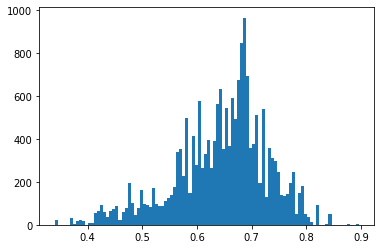

In [20]:
plt.hist(df_trades['max_similarity'], bins=100)
plt.show()
plt.close()

In [73]:
security_committees = [
    'homeland security',
    'armed services',
    'strategic forces',
    'national security',
    'military personnel',
    'military construction and veterans affairs',
    'homeland security and governmental affairs',
    'crime terrorism and homeland security',
    'defense',
    'defense intelligence overhead architecture'
]

tech_committees = [
    'cyber innovative technologies and information systems',
    'energy and commerce',
    'research and technology',
    'cybersecurity infrastructure protection and innovation',
    'transportation and infrastructure',
    'science space and technology',
    'digital assets financial technology and inclusion',
    'innovation data and commerce',
    'europe energy the environment and cyber',
    'communications technology',
    'communications and technology',
    'innovation entrepreneurship and workforce development',
    'biotechnology horticulture and research',
    'space and science'
]

agriculture_committees = [
    'livestock and foreign agriculture',
    'agriculture nutrition and forestry',
    'agriculture',
    'food and nutrition specialty crops organics and research',
    'agriculture rural development food and drug administration and related agencies',
    'biotechnology horticulture and research',
    'nutrition foreign agriculture and horticulture',
    'agriculture rural development food and drug administration',
    'livestock dairy poultry local food systems and food safety and security'
    ]

In [100]:
wealths = {}
for j, _committee in enumerate([agriculture_committees, tech_committees, security_committees]):
    _wealths = {}
    for sim_cutoff in np.arange(0.5, 1.0, 0.05):
        df_sub = df_trades[(df_trades['max_similarity'] >= sim_cutoff) & (df_trades['max_committee'].isin(_committee))].copy()

        ws_in = [wealth_initial]

        for i, date in enumerate(dates):
            wealth = ws_in[-1]

            portfolio = df_sub.loc[(df_sub.week_date == date), :].copy()
            portfolio['ticker'] = portfolio['ticker'].cat.remove_unused_categories()

            average_size = portfolio.groupby('ticker')['average_size'].sum().to_frame().reset_index()
            portfolio = portfolio.groupby('ticker')['size_score'].sum().sort_values().to_frame().reset_index()

            portfolio = portfolio.merge(average_size, how='left', on='ticker')
            portfolio = portfolio.merge(df_prices.loc[df_prices.Date == date, :], how='left', left_on='ticker', right_on='Ticker').drop(columns=['Ticker'])
            portfolio.dropna(subset=['Close', 'Close_lag'], inplace=True)

            cutoff = int(portfolio.shape[0] / 3)
            
            if portfolio.shape[0] > 0:

                short = portfolio[:cutoff].copy()
                long = portfolio[-cutoff:].copy()

                long['weights'] = np.abs(long['average_size']) / np.abs(long['average_size']).sum()
                short['weights'] = np.abs(short['average_size']) / np.abs(short['average_size']).sum()

                scale = 0.3 if short.shape[0] > 0 else 0.0

                long['holding_value'] = long['weights'] * wealth * (1 + scale)
                short['holding_value'] = short['weights'] * wealth * -scale

                long['holding_size'] = long['holding_value'] / long['Close']
                short['holding_size'] = short['holding_value'] / short['Close']

                long['holding_value_next'] = long['holding_size'] * long['Close_lag']
                short['holding_value_next'] = short['holding_size'] * short['Close_lag']

                # long['return'] = long['holding_value_next'] - long['holding_value']
                # short['return'] = short['holding_value_next'] - short['holding_value']

                wealth_long_new = long['holding_value_next'].sum()
                wealth_short_new = short['holding_value_next'].sum()

                wealth_new = wealth_long_new + wealth_short_new

            ws_in.append(wealth_new)

        _wealths[sim_cutoff] = ws_in

    wealths[['agri', 'tech', 'defense'][j]] = _wealths


In [90]:
agri_index = pd.read_csv(os.path.join(PATH_DATA, 'indicies', 'agri_index.csv'), parse_dates=['date'])
agri_index = agri_index[agri_index.date.dt.day_of_week == 4]

tech_index = pd.read_csv(os.path.join(PATH_DATA, 'indicies', 'tech_index.csv'), parse_dates=['date'])
tech_index = tech_index[tech_index.date.dt.day_of_week == 4]

defence_index = pd.read_csv(os.path.join(PATH_DATA, 'indicies', 'defence_index.csv'), parse_dates=['date'],)
defence_index = defence_index[defence_index.date.dt.day_of_week == 4]



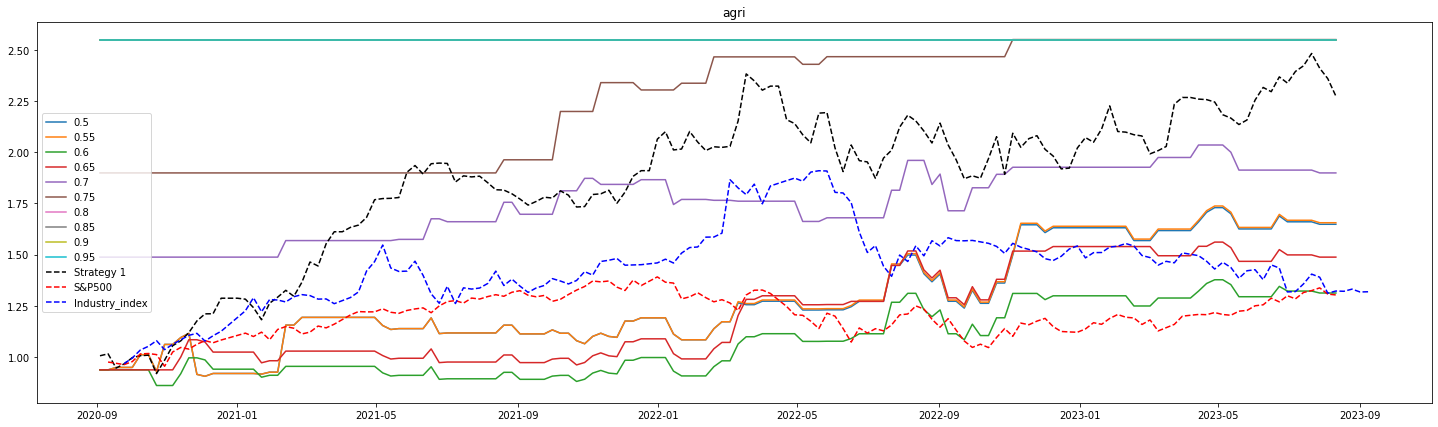

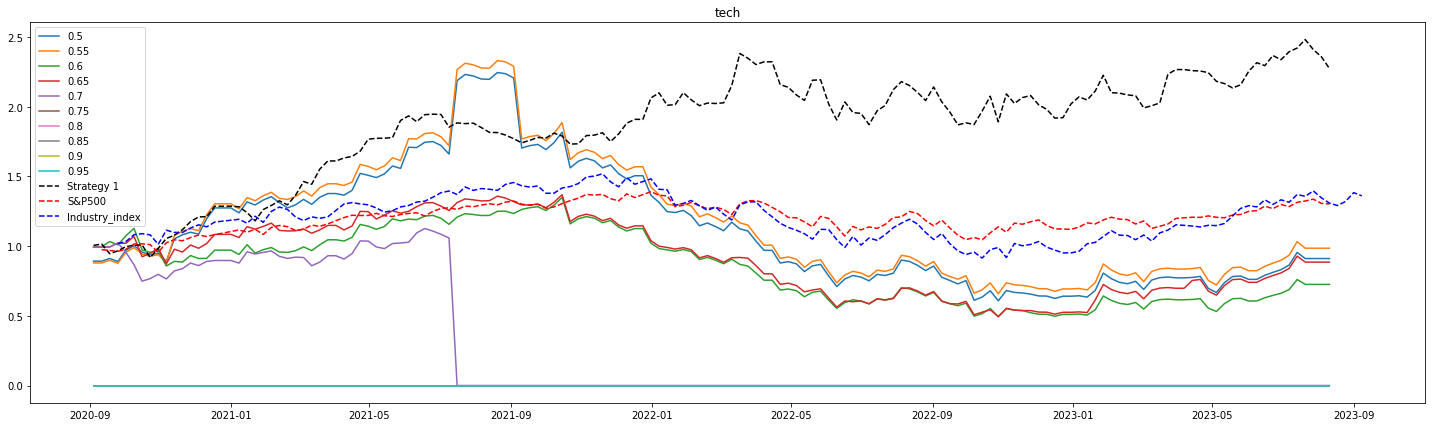

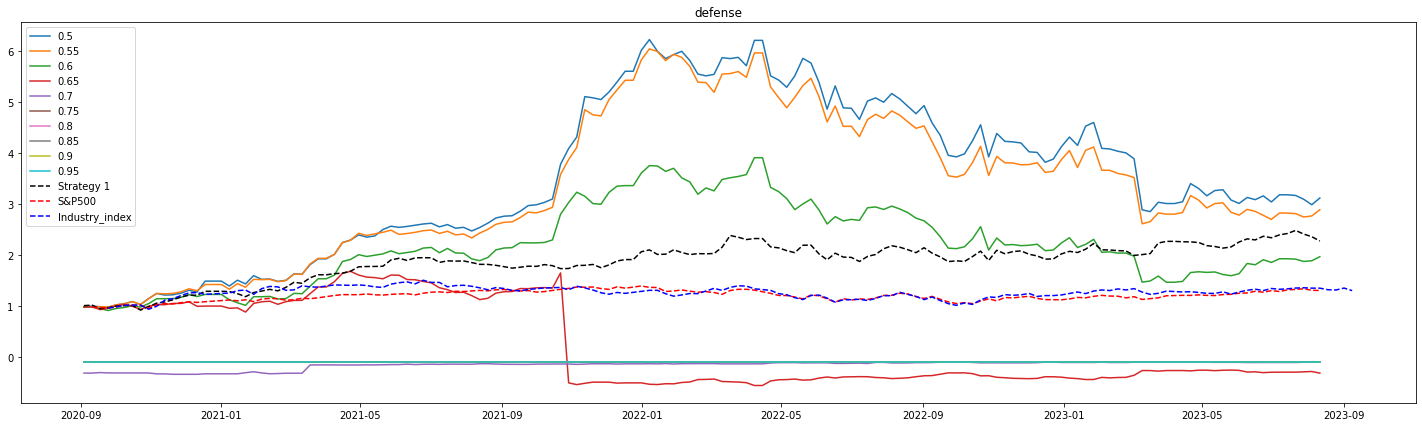

In [101]:
for _committee, idx in zip(['agri', 'tech', 'defense'], [agri_index, tech_index, defence_index]):
    n_idx_shares = wealth_initial / idx.iloc[0, 1]

    plt.figure(figsize=(25, 7))

    for cutoff in np.arange(0.5, 1.0, 0.05):
        plt.plot(dates, [w/wealth_initial for w in wealths[_committee][cutoff][1:]], label=str(round(cutoff, 2)))

    plt.plot(dates, [w/wealth_initial for w in ws_a1[1:]], '--k', label='Strategy 1')
    plt.plot(spx.index[1:], (spx['Close'].iloc[1:] * n_spx_shares) / wealth_initial, '--r', label='S&P500')
    plt.plot(idx.iloc[1:, 0], (idx.iloc[1:, 1] * n_idx_shares) / wealth_initial, '--b', label='Industry_index')
    plt.title(_committee)
    plt.legend()
    plt.show()
    plt.close()


In [106]:
list(wealths[_committee].keys())

[0.5,
 0.55,
 0.6000000000000001,
 0.6500000000000001,
 0.7000000000000002,
 0.7500000000000002,
 0.8000000000000003,
 0.8500000000000003,
 0.9000000000000004,
 0.9500000000000004]

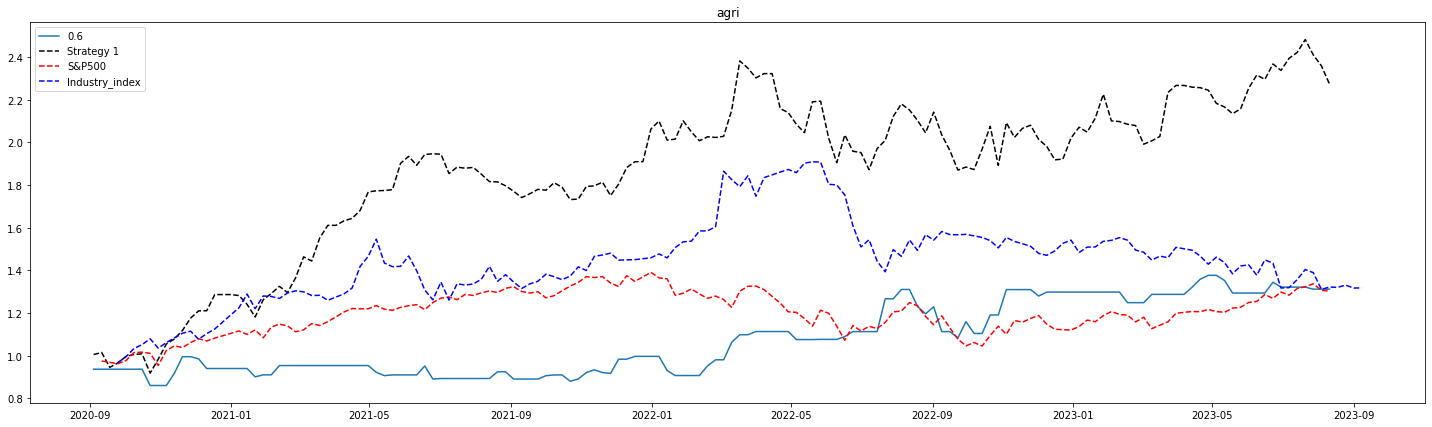

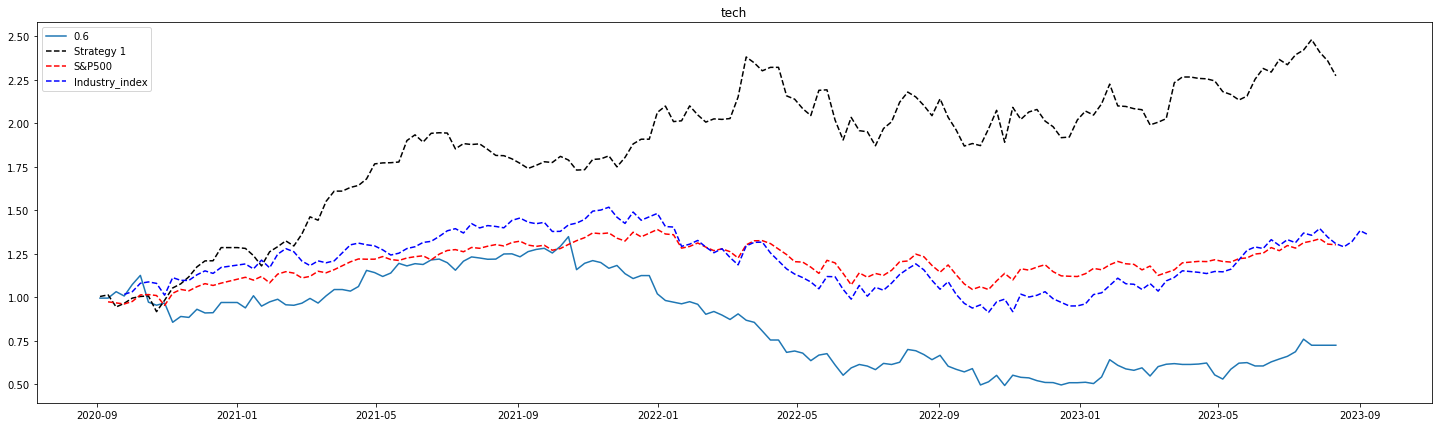

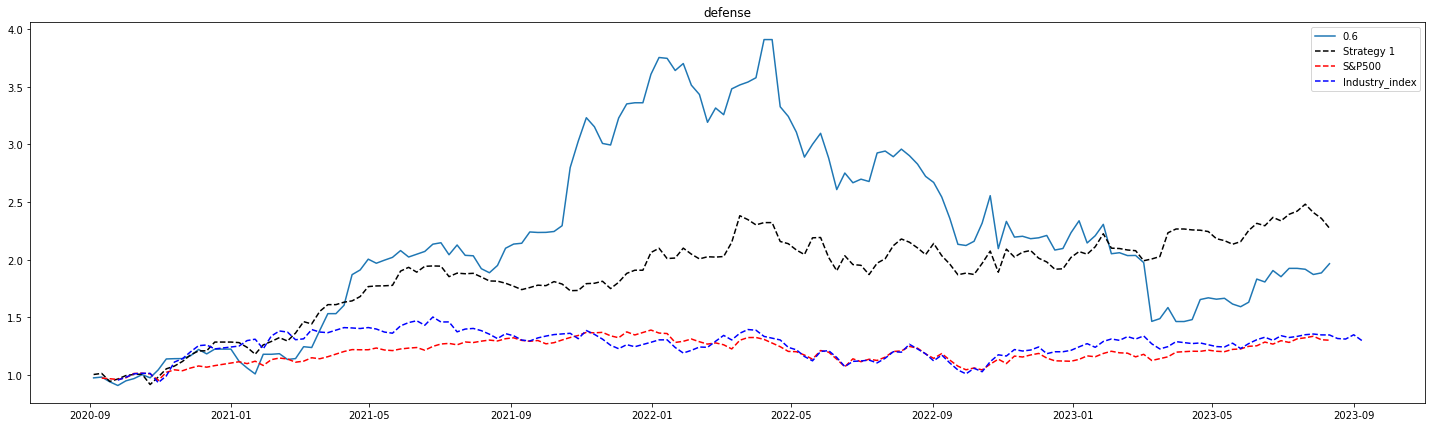

In [107]:
for _committee, idx in zip(['agri', 'tech', 'defense'], [agri_index, tech_index, defence_index]):
    n_idx_shares = wealth_initial / idx.iloc[0, 1]

    plt.figure(figsize=(25, 7))

    plt.plot(dates, [w/wealth_initial for w in wealths[_committee][0.6000000000000001][1:]], label=str(0.6))

    plt.plot(dates, [w/wealth_initial for w in ws_a1[1:]], '--k', label='Strategy 1')
    plt.plot(spx.index[1:], (spx['Close'].iloc[1:] * n_spx_shares) / wealth_initial, '--r', label='S&P500')
    plt.plot(idx.iloc[1:, 0], (idx.iloc[1:, 1] * n_idx_shares) / wealth_initial, '--b', label='Industry_index')
    plt.title(_committee)
    plt.legend()
    plt.show()
    plt.close()


### Manual cleaning of committees

# TODO



Then we need to compute the similarities between each trade's firm sector-industry and each politician-committee-membership and take the max.

Then, we filter by max-similarity and build a long short portfolio to see if we beat the vanilla portfolio.

Finally, we compute the factor model alphas.

Bam, done.
